# The Full Pipeline for Exploiting Loop-Like Exercices in The Classification of Parkinson's Disease

## Content

1. Data Preparation
    1. Data Collection
    2. Preprocessing
    3. Splitting
1. Exploratory Data Analysis
    1. Basic Statistical Measures
    2. Plotting
1. Data Manipulation
    1. Feature Extraction
    2. Preliminary Feature Selection
    3. Interpolation
    4. Normalization
1. Model Architecture Design
1. Model Compilation
1. Model Training
1. Model Tuning and Evaluation

## 1. Data Preparation

### A. Data Collection

<p>In this phase, the data is loaded from the files that were created by the data collection system.</p>
<p>This is done using packages and modules specifically designed for the hierarchical structure of this data.</p>
<p>The module responsible for data collection also performs some basic preprocessing tasks, such as removing invalid data that shouldn't exist (e.g. letters in numeric values).</p>
<p>The data concerning the cursive <em>"L"</em> task in the French language is loaded.</p>

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

from dataaccess.filedatareader import FileDataReader

reader = FileDataReader('../data/Patients Records 05_04_2019')
info, data = reader.load_french(tasks=[3])

Loading the data, please wait.
Data loaded successfully.


### B. Preprocessing

<p>In the preprocessing phase, the following steps are carried:</p>
<ol>
    <li>Handling missing data.</li>
    <li>Keeping only the data of healthy controls (HCs) and parkinson's disease patients (PDs).</li>
</ol>
<p>In our case, since there are no missing values in the data concerning Task 3 in French anyways, missing data is already handled.</p>
<p>Any exercice that doesn't correspond to an HC or a PD is removed (e.g. Alzheimers...).</p>

In [2]:
from datamanipulation.datageneration import get_pd_hc_only

info, data = get_pd_hc_only(info, data)

### C. Splitting

<p>In the splitting phase, I divide the dataset into training and test sets. The training set is used to train the model, and the test set (which is 30% of the data) evaluates the final model's performance, the test set is stratified to resemble the original data's label distrobution as much as possible.</p>
<p>Since the data size is limiting, no validation set was left out, instead, 3-fold cross validation is used later.</p>
<p>In the following phases, only the training data is used.</p>

In [3]:
from datamanipulation.datageneration import stratified_train_test_split

info_train, info_test, data_train, data_test = stratified_train_test_split(info, data, 'PD')

## 2. Exploratory Data Analysis

### A. Basic Statistical Measures

<p>The first thing that can be noticed, is that the distrobution between HCs and PDs is very biased, which can create generalization problems, these problems can be observed in specificity and sensitivity.</p>

In [4]:
df = info_train.groupby('PD').count()[["Age"]]
df.columns = ['Count']
df

,Count
PD,
0,100
1,15


There is also another problem with the data, which is that the data is supposed to be spaced equaly in time (7ms and 8ms only), but there are a lot of images that contain data points that change eratically in time as follows:

In [5]:
hcs = data_train[data_train['PD']==0]
pds = data_train[data_train['PD']==1]

print('Example of non consistent time changes in a random image: ', list(pds.loc[pds.index.unique()[4]]['Time'].diff().where(lambda x: x > 8).dropna()))

Example of non consistent time changes in a random image:  [1660.0, 108.0, 41.0, 73.0, 9.0, 747.0, 17.0, 715.0, 17.0, 70.0, 36.0, 20.0]


In [6]:
def calc_variable_time_change(df):
    count = 0
    for ix in df.index.unique():
        if len(df.loc[ix]['Time'].diff().unique()) > 3:
            count += 1
    return '{:.2f}'.format((count / df.index.unique().shape[0]) * 100) + "%"

print('The percentage of images that contain a variable time change:')
print('PDs:', calc_variable_time_change(pds))
print('HCs:', calc_variable_time_change(hcs))
print('All:', calc_variable_time_change(data_train))
print()

def calc_variable_time_change2(df):
    count = 0
    for ix in df.index.unique():
        count += df.loc[ix]['Time'].diff().where(lambda x: x > 8).dropna().shape[0]
    return '{:.2f}'.format((count / df.shape[0]) * 100) + "%"

print('The percentage of data points that contain a variable time change:')
print('PDs:', calc_variable_time_change2(pds))
print('HCs:', calc_variable_time_change2(hcs))
print('All:', calc_variable_time_change2(data_train))

The percentage of images that contain a variable time change:
PDs: 53.33%
HCs: 58.00%
All: 57.39%

The percentage of data points that contain a variable time change:
PDs: 0.07%
HCs: 0.15%
All: 0.14%


The negligeable number of data points that have a variable change in time, shows that they can be completely ignored, so from now on data is treated as if it has a consistent time change.

<p>Now let's compare some basic statistical measures between PDs and HCs.</p>
<p>Starting with PDs:</p>

In [7]:
pds.describe()

,PD,Time,X,Y,P,Az,Al
count,36537.0,36537.000000,36537.000000,36537.000000,36537.00000,36537.000000,36537.000000
mean,1.0,10925.115198,10268.176260,34983.039193,330.36448,1445.793305,521.731122
std,0.0,7487.616698,6171.477979,3965.842672,266.08722,368.802523,142.914394
min,1.0,0.000000,9.000000,25412.000000,0.00000,0.000000,220.000000
25%,1.0,4878.000000,4403.000000,31504.000000,0.00000,1280.000000,430.000000
50%,1.0,9901.000000,7859.000000,33065.000000,350.00000,1430.000000,510.000000
75%,1.0,15532.000000,16295.000000,39129.000000,559.00000,1610.000000,570.000000
max,1.0,31479.000000,22425.000000,40629.000000,1023.00000,3460.000000,900.000000


Then HCs:

In [8]:
hcs.describe()

,PD,Time,X,Y,P,Az,Al
count,152512.0,152512.000000,152512.000000,152512.000000,152512.000000,152512.000000,152512.000000
mean,0.0,9014.172616,10882.636947,34565.529670,479.301524,1547.885609,536.751928
std,0.0,9878.625083,6507.945597,4384.802017,1373.765751,447.032386,132.333951
min,0.0,0.000000,9.000000,9157.000000,0.000000,0.000000,-900.000000
25%,0.0,3074.000000,4750.000000,31295.000000,0.000000,1300.000000,460.000000
50%,0.0,6139.000000,9675.000000,32401.000000,407.000000,1540.000000,520.000000
75%,0.0,10663.250000,16710.000000,39016.000000,612.000000,1750.000000,590.000000
max,0.0,58572.000000,51156.000000,40639.000000,23194.000000,3580.000000,900.000000


<ul>
    <li>Time: The most important distinction when it comes to time, is that the mean, first quartile, median, and third quartile, are all higher in PDs than in HCs, which indicates that generaly, PDs take more time to complete the exercices than HCs.</li>
    <li>Movement in X and Y: Slight micrographia is also noticed in the X and Y axis for PDs, especially in the X axis.</li>
    <li>The pressure is also signicantly less in PDs than in HCs, with a huge difference in its standard deviation.</li>
    <li>When it comes to altitude, HCs seem to hold the pen a little bit straighter than PDs.</li>
</ul>

The correlation matrix for all participants:

In [9]:
data_train.corr(numeric_only=True)

,PD,Time,X,Y,P,Az,Al
PD,1.000000,0.079480,-0.037623,0.038249,-0.047396,-0.092696,-0.044073
Time,0.079480,1.000000,0.203815,0.440181,-0.025178,0.014295,-0.214067
X,-0.037623,0.203815,1.000000,-0.053756,-0.010190,-0.064940,0.042583
Y,0.038249,0.440181,-0.053756,1.000000,0.021805,0.029710,-0.130257
P,-0.047396,-0.025178,-0.010190,0.021805,1.000000,0.048866,-0.005480
Az,-0.092696,0.014295,-0.064940,0.029710,0.048866,1.000000,0.026142
Al,-0.044073,-0.214067,0.042583,-0.130257,-0.005480,0.026142,1.000000


The correlation matrix for PDs:

In [10]:
pds.corr(numeric_only=True)

,PD,Time,X,Y,P,Az,Al
PD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Time,NaN,1.000000,0.400210,0.693595,-0.005355,-0.113560,-0.215059
X,NaN,0.400210,1.000000,0.086689,0.045959,-0.016592,-0.040511
Y,NaN,0.693595,0.086689,1.000000,-0.000007,-0.072722,-0.259562
P,NaN,-0.005355,0.045959,-0.000007,1.000000,-0.018884,-0.166203
Az,NaN,-0.113560,-0.016592,-0.072722,-0.018884,1.000000,0.103091
Al,NaN,-0.215059,-0.040511,-0.259562,-0.166203,0.103091,1.000000


The correlation matrix for HCs:

In [11]:
hcs.corr(numeric_only=True)

,PD,Time,X,Y,P,Az,Al
PD,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Time,NaN,1.000000,0.175211,0.397981,-0.022850,0.042117,-0.212914
X,NaN,0.175211,1.000000,-0.080979,-0.015306,-0.078657,0.061059
Y,NaN,0.397981,-0.080979,1.000000,0.025993,0.052420,-0.098575
P,NaN,-0.022850,-0.015306,0.025993,1.000000,0.049163,-0.000289
Az,NaN,0.042117,-0.078657,0.052420,0.049163,1.000000,0.005044
Al,NaN,-0.212914,0.061059,-0.098575,-0.000289,0.005044,1.000000


- There doesn't seem to be any strong correlation between any of the feature in PDs, HCs and both, except for the time's correlation with X and Y which is normal considering the direction of writing.
- There is however a big difference in the correlation between time and position, in between HCs and PDs; HCs have a higher correlation, which is due to their writing being faster, so it adapts better to the fast change in time.

### B. Plotting

First let's view the handwriting differences:

In [12]:
import numpy as np

def rand_imgs(num):
    rand_hcs = []
    rand_pds = []
    for i in range(num):
        rand_hcs.append(np.random.randint(0, len(hcs.index.unique())))
        rand_pds.append(np.random.randint(0, len(pds.index.unique())))
    hc_images = []
    pd_images = []
    for i, j in zip(rand_hcs, rand_pds):
        hc_images.append(hcs.loc[hcs.index.unique()[i]])
        pd_images.append(pds.loc[pds.index.unique()[j]])
    return hc_images, pd_images

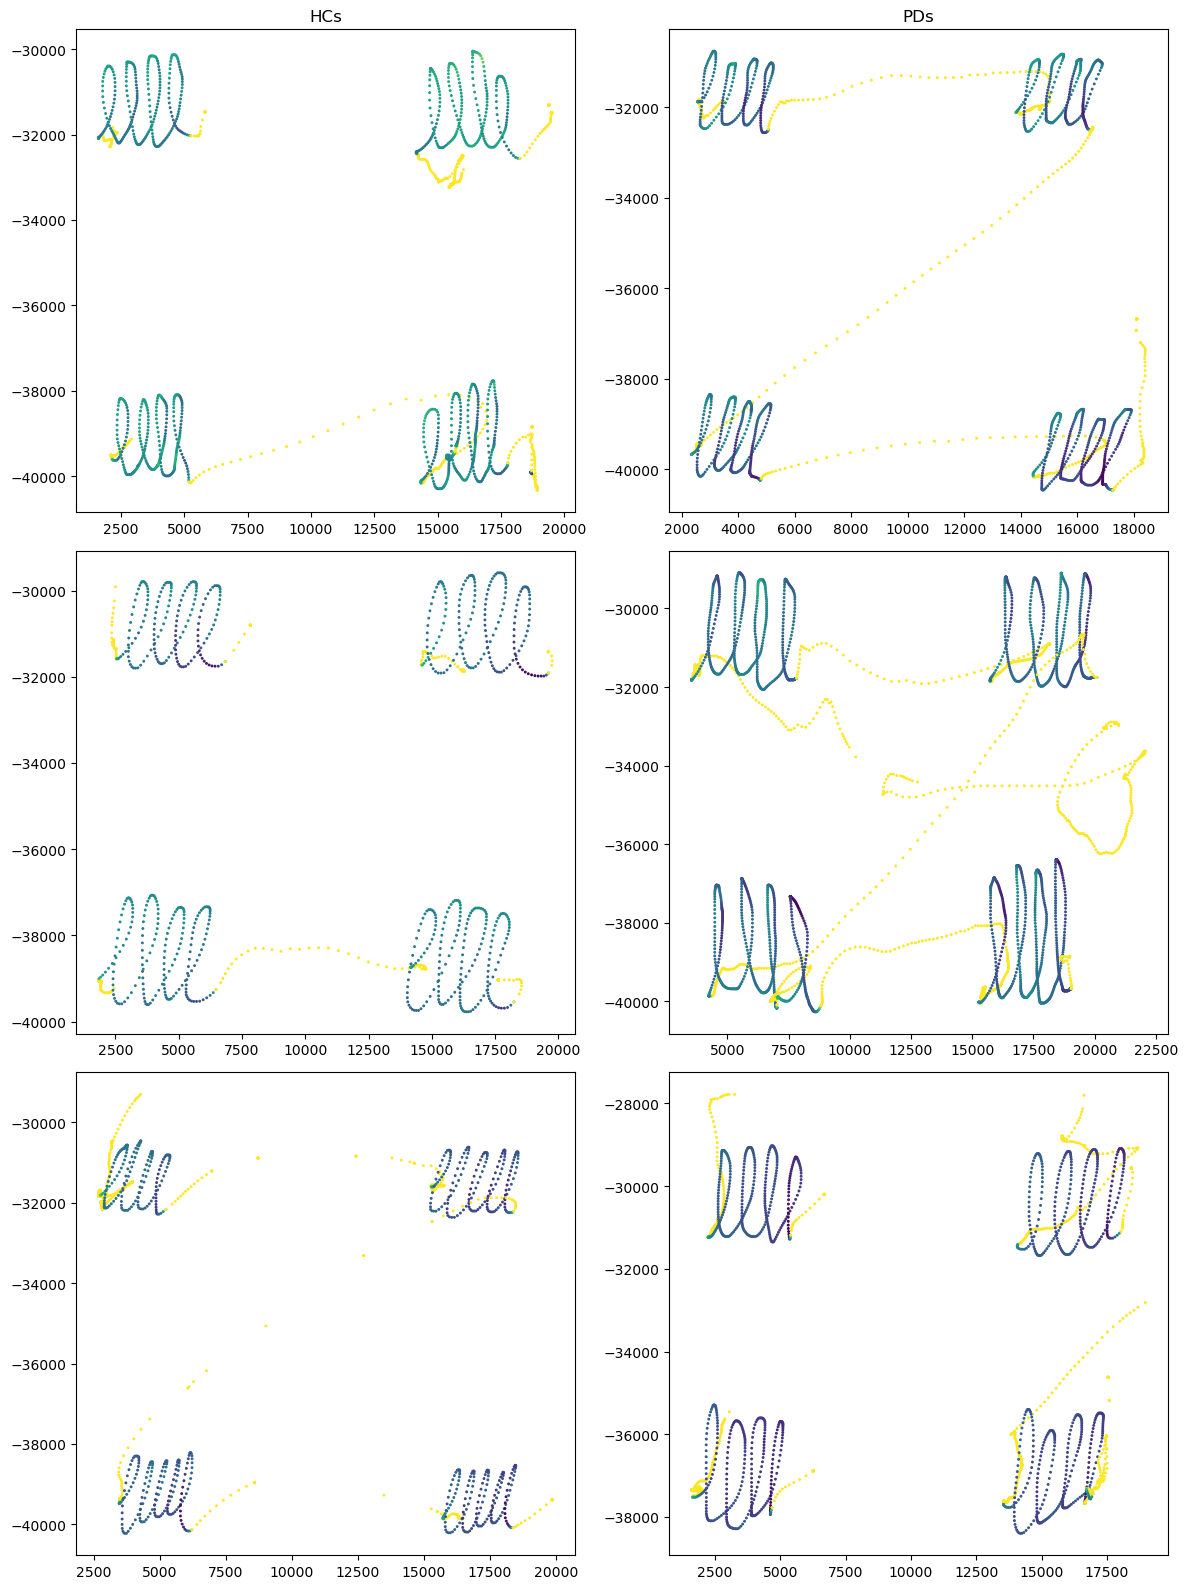

In [13]:
import matplotlib.pyplot as plt

rand_hcs, rand_pds = rand_imgs(3)

plt.close()

fig = plt.figure(figsize=(12, 16))

hc_plot1 = plt.subplot2grid((3, 2), (0, 0))
hc_plot2 = plt.subplot2grid((3, 2), (1, 0))
hc_plot3 = plt.subplot2grid((3, 2), (2, 0))

pd_plot1 = plt.subplot2grid((3, 2), (0, 1))
pd_plot2 = plt.subplot2grid((3, 2), (1, 1))
pd_plot3 = plt.subplot2grid((3, 2), (2, 1))

hc_plot1.set_title('HCs')
hc_plot1.scatter(rand_hcs[0]['X'], rand_hcs[0]['Y'] *-1, c=rand_hcs[0]['P']*-1, s=1.2)
hc_plot2.scatter(rand_hcs[1]['X'], rand_hcs[1]['Y'] *-1, c=rand_hcs[1]['P']*-1, s=1.2)
hc_plot3.scatter(rand_hcs[2]['X'], rand_hcs[2]['Y'] *-1, c=rand_hcs[2]['P']*-1, s=1.2)

pd_plot1.set_title('PDs')
pd_plot1.scatter(rand_pds[0]['X'], rand_pds[0]['Y'] *-1, c=rand_pds[0]['P']*-1, s=1.2)
pd_plot2.scatter(rand_pds[1]['X'], rand_pds[1]['Y'] *-1, c=rand_pds[1]['P']*-1, s=1.2)
pd_plot3.scatter(rand_pds[2]['X'], rand_pds[2]['Y'] *-1, c=rand_pds[2]['P']*-1, s=1.2)

plt.tight_layout()
plt.show()

- It's very clear that the HC's handwriting (HW) and in-air movements are far smoother than that of the PD, in mathematical terms, this means that there is some volatility in the change in X and Y, especialy observed in the X-axis.
- This information can be further exploited with some extracted features such the change in X and Y, velocity, acceleration and jerk.
- There is also a slight change in pressure, illustrated by the colors, where the bluer the color the higher the pressure, PDs show less pressure which is especially noticeable in the top of each "L" as time goes on, this may be due to fatigue in PDs.
- Then the change in pressure and the rate of change in pressure could show these patterns more clearly.
- There is also noticeable micrographia in the X and Y axes, and a higher density of points in PDs, which indicates slower movement and more time spent in HW.

## 3. Data Manipulation

### A. Feature Extraction

In this phase, we perform feature extraction and produce features that may be of value, as discovered in the exploratory data analysis.

Since the data is represented as images, only the features that can have a value at each datapoint are used, so features that produce vectors of smaller size than the number of data points per image, or features that produce one scalar value per image, are ignored.

The following are the extracted features:

- Uni-dimensional features (extracted only in x or y axes)
    1. Displacement (Change in x or y).
- Multi-dimensional features (extracted in x, y or both axes)
    1. Distance.
    1. Velocity.
    1. Acceleration.
    1. Jerk.
- Change / Rates of change (ROC)
    1. Change in Pressure.
    1. Pressure over time.
    1. Alt over time.
    1. Az over time.
    1. The slope (ROC of y over x).
 
However since the time is consistent between each data point (7/8ms), The rates of change of variables over time won't be calculated, instead the change itself will be used, and the following list of features is the one that will actually be extracted:

- Uni-dimensional features (extracted only in x or y axes)
    1. Displacement (Change in x or y).
- Multi-dimensional features (extracted in x, y or both axes)
    1. Distance.
- Change / Rates of Change (ROC)
    1. Change in distance (alternative to velocity).
    1. 2nd change in distance (alternative to acceleration).
    1. 3rd change in distance (alternative to jerk).
    1. Change in pressure.
    1. Change in alt.
    1. Change in az.
    1. The slope (ROC of y over x).

In [13]:
from datamanipulation.extraction import *

extracted_train = extract_features(data_train, pipe=feature_extraction_pipe)

Started extracting features.
The following features were extracted successfully: Index(['Displacement x', 'Displacement y', 'Distance x', 'Distance y',
       'Distance x-y', 'Change distance x', 'Change distance y',
       'Change distance x-y', '2nd change distance x', '2nd change distance y',
       '2nd change distance x-y', '3rd change distance x',
       '3rd change distance y', '3rd change distance x-y', 'Change p',
       'Change al', 'Change az', 'Slope'],
      dtype='object')


### B. Preliminary Feature Selection

In this phase, I perform statistical methods in order to get rid of features that are not needed.

In [52]:
import pandas as pd
pd.set_option('display.max_columns', None)
threshold = 0.5
extracted_train.corr().where(lambda x: ((x>threshold) | (x<-threshold)) & (x!=1) & (x!=-1)).count()

PD                          0
Time                        0
X                           0
Y                           0
P                           0
Az                          0
Al                          0
Displacement x              0
Displacement y              5
Distance x                  2
Distance y                  5
Distance x-y                6
Change distance x           5
Change distance y           9
Change distance x-y        11
2nd change distance x       5
2nd change distance y       5
2nd change distance x-y     8
3rd change distance x       4
3rd change distance y       5
3rd change distance x-y     7
Change p                    0
Change al                   5
Change az                   0
Slope                       0
dtype: int64

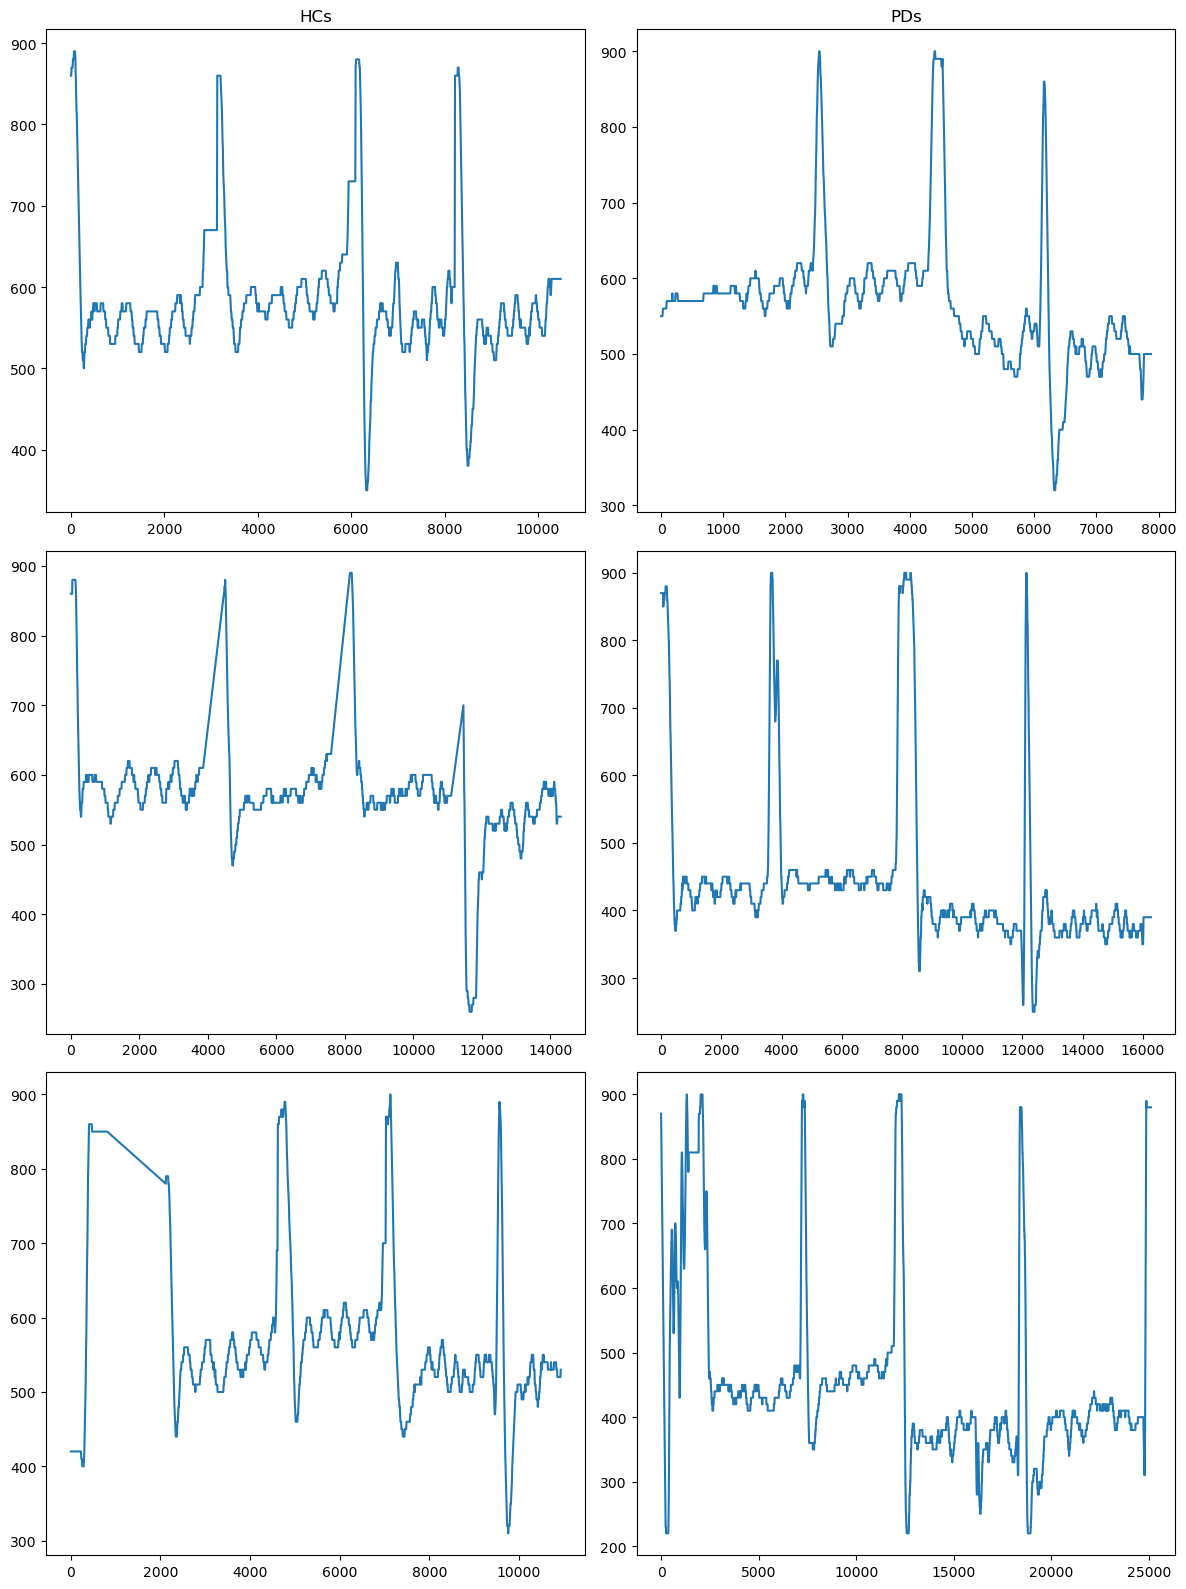

In [61]:
var = 'Al'
over = 'Time'

plt.close()

fig = plt.figure(figsize=(12, 16))

hc_plot1 = plt.subplot2grid((3, 2), (0, 0))
hc_plot2 = plt.subplot2grid((3, 2), (1, 0))
hc_plot3 = plt.subplot2grid((3, 2), (2, 0))

pd_plot1 = plt.subplot2grid((3, 2), (0, 1))
pd_plot2 = plt.subplot2grid((3, 2), (1, 1))
pd_plot3 = plt.subplot2grid((3, 2), (2, 1))

hc_plot1.set_title('HCs')
hc_plot1.plot(rand_hcs[0][over], rand_hcs[0][var])
hc_plot2.plot(rand_hcs[1][over], rand_hcs[1][var])
hc_plot3.plot(rand_hcs[2][over], rand_hcs[2][var])

pd_plot1.set_title('PDs')
pd_plot1.plot(rand_pds[0][over], rand_pds[0][var])
pd_plot2.plot(rand_pds[1][over], rand_pds[1][var])
pd_plot3.plot(rand_pds[2][over], rand_pds[2][var])

plt.tight_layout()
plt.show()

In [13]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

original_img = np.array(get_random_image(X, y, 0))
original_height, original_width = original_img.shape

new_shape = (original_img.shape[0] - 300, original_img.shape[1])

scaled_img = tf.image.resize(
    original_img.reshape((original_height, original_width, 1)),
    new_shape,
    method=tf.image.ResizeMethod.BILINEAR
)
scaled_img = tf.reshape(scaled_img, new_shape)

plt.close()
plt.figure(1)

plt.subplot(1, 2, 1)
plt.subplots_adjust(right=4)
plt.title('Original')
plt.scatter(original_img[:,1], original_img[:,2] * -1, c=original_img[:,3] + 1, s=1)

plt.subplot(1, 2, 2)
plt.subplots_adjust(left=4, right=5)
plt.title('Scaled')
plt.scatter(scaled_img[:,1], scaled_img[:,2] * -1, c=scaled_img[:,3] + 1, s=1)
plt.show()

NameError: name 'get_random_image' is not defined

In [20]:
import numpy as np

X1 = np.zeros((10, 6))
X1[:, 0] = np.arange(0, 8*10, 8)
X1[:, 1:] = np.random.randint(10, size=(10, 5))

X2 = np.zeros((12, 6))
X2[:, 0] = np.arange(0, 8*12, 8)
X2[:, 1:] = np.random.randint(10, size=(12, 5))

X = np.vstack((X1, X2))

In [63]:
import pandas as pd

df = pd.DataFrame(X, columns=['Time', 'X', 'Y', 'P', 'Az', 'Al'])
df['ID'] = df.apply(lambda x: 'a' if int(x.name) < 10 else 'b', axis=1)
df['Language'] = 'French'
df['Task'] = 3
df.set_index(['ID', 'Language', 'Task'], inplace=True)
df.loc['a', 'French', 3] = X1 * 2
df.loc['a', 'French', 3]

Time     X     Y     P    Az    Al
ID Language Task                                     
a  French   3       0.0  14.0  10.0  18.0  16.0   2.0
            3      16.0  12.0  16.0   6.0  12.0  14.0
            3      32.0   4.0  16.0  10.0  18.0  14.0
            3      48.0  12.0   8.0   6.0  18.0   2.0
            3      64.0   4.0   6.0   6.0   2.0   0.0
            3      80.0  16.0  16.0  18.0   2.0  14.0
            3      96.0   6.0  12.0   8.0   4.0   4.0
            3     112.0   8.0   4.0  12.0  10.0  14.0
            3     128.0   6.0  14.0   0.0   4.0  10.0
            3     144.0  16.0   6.0   4.0  14.0  16.0

array([[  0.,  14.,  10.,  18.,  16.,   2.],
       [ 16.,  12.,  16.,   6.,  12.,  14.],
       [ 32.,   4.,  16.,  10.,  18.,  14.],
       [ 48.,  12.,   8.,   6.,  18.,   2.],
       [ 64.,   4.,   6.,   6.,   2.,   0.],
       [ 80.,  16.,  16.,  18.,   2.,  14.],
       [ 96.,   6.,  12.,   8.,   4.,   4.],
       [112.,   8.,   4.,  12.,  10.,  14.],
       [128.,   6.,  14.,   0.,   4.,  10.],
       [144.,  16.,   6.,   4.,  14.,  16.],
       [  0.,   8.,   8.,   6.,   2.,   2.],
       [  8.,   0.,   4.,   6.,   4.,   6.],
       [ 16.,   1.,   9.,   5.,   6.,   1.],
       [ 24.,   4.,   9.,   1.,   4.,   8.],
       [ 32.,   6.,   0.,   2.,   2.,   2.],
       [ 40.,   9.,   8.,   3.,   7.,   3.],
       [ 48.,   7.,   6.,   0.,   2.,   4.],
       [ 56.,   7.,   0.,   7.,   5.,   9.],
       [ 64.,   0.,   4.,   7.,   3.,   8.],
       [ 72.,   4.,   2.,   1.,   3.,   3.],
       [ 80.,   4.,   8.,   0.,   5.,   5.],
       [ 88.,   8.,   1.,   5.,   4.,   3.]])

In [13]:
np.sqrt(3**2+(5-8)**2)

4.242640687119285

In [153]:
np.inf * 21

inf

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(img_original[:,0], img_original[:,3], label='Noisy Data')
plt.plot(img_extracted[:,0], img_extracted[:,-1], label='Smoothed')
plt.legend()
plt.title('Median Smoothing')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

y.reshape(-1, 1).reshape(-1)

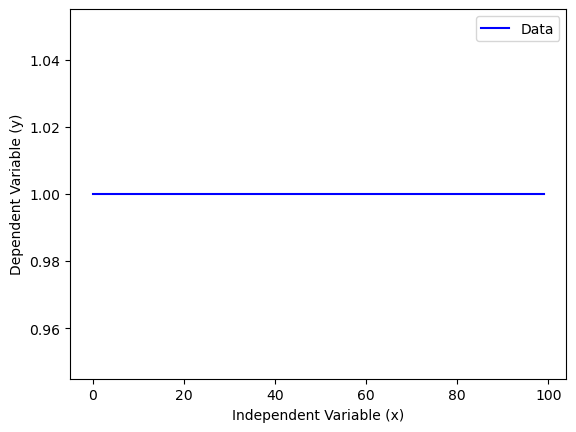

In [34]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0, 100, 1)
y = np.ones(100)

plt.plot(x, y, c='blue', label='Data')
plt.xlabel('Independent Variable (x)')
plt.ylabel('Dependent Variable (y)')
plt.legend()
plt.show()

44